#Importation of Libraries and Datasets

In [ ]:
#Importation of the libraries
import pandas as pd
import numpy as np
import re
from scipy import stats
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import datetime

In [ ]:
from importlib_metadata import version
print("Versione libreria pandas: " + version('pandas'))
print("Versione libreria numpy: " + version('numpy'))
print("Versione libreria re: " + version('regex'))
print("Versione libreria scipy: " + version('scipy'))
print("Versione libreria matplotlib: " + version('matplotlib'))
print("Versione libreria seaborn: " + version('seaborn'))

Versione libreria pandas: 1.3.5
Versione libreria numpy: 1.21.6
Versione libreria re: 2022.6.2
Versione libreria scipy: 1.7.3
Versione libreria matplotlib: 3.2.2
Versione libreria seaborn: 0.11.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Progetto_Web/Dataset_Script/Dataset/'

In [ ]:
# df1: contiene informazioni sugli abbonamenti fedeltà di ciascun account cliente
df1 = pd.read_csv(BASE_PATH + 'raw_1_cli_fid.csv', sep = ';', na_values = '', encoding = 'latin-1')
# df2: contiene informazioni su ciascun account cliente e descrive le caratteristiche di esse, tra la prima tabella e la seconda ci sono dei duplicati, 
# per esempio, perché un cliente può avere più tessere fedeltà o la stessa tessera fedeltà può appartenere a più clienti
df2 = pd.read_csv(BASE_PATH + 'raw_2_cli_account.csv', sep = ';', na_values = '', encoding = 'latin-1')
# df3: contiene informazioni sull'indirizzo corrispondente a un account cliente
df3 = pd.read_csv(BASE_PATH + 'raw_3_cli_address.csv', sep = ';', na_values = '', encoding = 'latin-1')
# df4: contiene informazioni sulle politiche sulla privacy accettate da ciascun cliente
df4 = pd.read_csv(BASE_PATH + 'raw_4_cli_privacy.csv', sep = ';', na_values = '', encoding = 'latin-1')
# df7: contiene le transazioni di acquisto e rimborso di ciascun cliente, è una delle parti più cospicue di questa base di dati
df7 = pd.read_csv(BASE_PATH + 'raw_7_tic.csv', sep = ';', na_values = '', encoding = 'latin-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# df1

In [ ]:
#Check for duplicates
print('Check for duplicates')
print(f'Number of rows duplicated = {len(df1[df1.duplicated()])}')
print(f"Number of ID_FID's values duplicated = {len(df1[df1.duplicated('ID_FID')])}")
print(f"Number of ID_CLI's values duplicated = {len(df1[df1.duplicated('ID_CLI')])}")
print(f"Number of duplicates for combination ID_CLI and ID_FID = {len(df1[df1.duplicated(subset = {'ID_FID', 'ID_CLI'})])}")

Check for duplicates
Number of rows duplicated = 0
Number of ID_FID's values duplicated = 2210
Number of ID_CLI's values duplicated = 663
Number of duplicates for combination ID_CLI and ID_FID = 0


In [ ]:
#Formatting dates
df1['DT_ACTIVE'] = pd.to_datetime(df1['DT_ACTIVE'])
#Formatting boolean as category
df1 = df1.astype({'TYP_CLI_FID': 'category', 'STATUS_FID': 'category'})

In [ ]:
#CONSISTENCY CHECK on df1: number of fidelity subscriptions per client
#Count the subscriptions for each client
num_fid_x_cli = df1.groupby('ID_CLI', as_index=False)[['ID_FID', 'DT_ACTIVE']].nunique()
num_fid_x_cli.rename(columns={"ID_FID": "NUM_FIDs", "DT_ACTIVE": "NUM_DATEs"}, inplace = True)
tot_id_cli = len(num_fid_x_cli)
tot_id_cli

369472

In [ ]:
#Compute the distribution of number of subscriptions
dist_num_fid_x_cli = num_fid_x_cli.groupby(by=['NUM_FIDs', 'NUM_DATEs'], as_index=False)[['ID_CLI']].nunique()
dist_num_fid_x_cli.rename(columns={"ID_CLI": "TOT_CLIs"}, inplace = True)
dist_num_fid_x_cli['PERCENT_CLIs'] = dist_num_fid_x_cli['TOT_CLIs']/tot_id_cli
#NOTE: there are clients with multiple fidelity subscriptions!
dist_num_fid_x_cli

,NUM_FIDs,NUM_DATEs,TOT_CLIs,PERCENT_CLIs
0,1,1,368833,0.998271
1,2,1,254,0.000687
2,2,2,363,0.000982
3,3,1,7,0.000019
4,3,2,8,0.000022
5,3,3,5,0.000014
6,4,1,2,0.000005


In [ ]:
#Let examine in details clients with multiple subscriptions
num_fid_x_cli[num_fid_x_cli['NUM_FIDs'] == 3]

,ID_CLI,NUM_FIDs,NUM_DATEs
3035,7533,3,3
4653,11477,3,1
27509,68556,3,1
38708,96537,3,1
89340,223203,3,3
100095,250133,3,2
124787,311669,3,1
128374,320880,3,2
248625,621814,3,3
259387,648813,3,3


In [ ]:
#Each subscription can have different dates
df1[df1['ID_CLI'] == 621814]

,ID_CLI,ID_FID,ID_NEG,TYP_CLI_FID,COD_FID,STATUS_FID,DT_ACTIVE
233160,621814,578123,1,1,STANDARD,0,2018-10-13
260121,621814,646483,18,1,STANDARD,0,2018-11-13
265949,621814,661124,18,1,STANDARD,1,2018-11-20


In [ ]:
#Combining information
#From first subscription  --> registration date, store for registration
#From last subscription   --> type of fidelity, status
#From subscriptions count --> number of subscriptions made
df1_min_date = df1.groupby('ID_CLI', as_index = False)['DT_ACTIVE'].min()
df_1_cli_fid_first = df1_min_date.merge(df1, how = 'left')
df_1_cli_fid_first.sort_values('ID_FID', inplace = True)
duplicates_min = df_1_cli_fid_first[df_1_cli_fid_first.duplicated('ID_CLI')]
index_min = list(duplicates_min.index.values)
df_1_cli_fid_first.drop(index_min, inplace = True)
df1_max_date = df1.groupby('ID_CLI', as_index = False)['DT_ACTIVE'].max()
df_1_cli_fid_last = df1_max_date.merge(df1, how = 'left')
df_1_cli_fid_last.sort_values('ID_FID', inplace = True, ascending = False)
duplicates_max = df_1_cli_fid_last[df_1_cli_fid_last.duplicated('ID_CLI')]
index_max = list(duplicates_max.index.values)
df_1_cli_fid_last.drop(index_max, inplace = True)
df_1_cli_fid_last.rename(columns={'COD_FID' : 'LAST_COD_FID', 'TYP_CLI_FID' : 'LAST_TYP_CLI_FID', 'STATUS_FID': 'LAST_STATUS_FID', 'DT_ACTIVE' : 'LAST_DT_ACTIVE'}, inplace = True)
df_1_cli_fid_first.rename(columns = {'ID_NEG' : 'FIRST_ID_NEG', 'DT_ACTIVE' : 'FIRST_DT_ACTIVE'}, inplace = True)
df_1_cli_fid_clean = pd.merge(df_1_cli_fid_last[['ID_CLI', 'ID_FID', 'LAST_COD_FID', 'LAST_TYP_CLI_FID', 'LAST_STATUS_FID', 'LAST_DT_ACTIVE']],df_1_cli_fid_first[['ID_CLI','FIRST_ID_NEG', 'FIRST_DT_ACTIVE']], on='ID_CLI', how='left')
df_1_cli_fid_clean = df_1_cli_fid_clean.merge(num_fid_x_cli[['ID_CLI', 'NUM_FIDs']], on='ID_CLI', how='left')
df_1_cli_fid_clean = df_1_cli_fid_clean.astype({'NUM_FIDs': 'category'})

df_1_cli_fid_clean.head()

,ID_CLI,ID_FID,LAST_COD_FID,LAST_TYP_CLI_FID,LAST_STATUS_FID,LAST_DT_ACTIVE,FIRST_ID_NEG,FIRST_DT_ACTIVE,NUM_FIDs
0,199060,928121,PREMIUM BIZ,1,1,2019-05-11,19,2018-02-18,2
1,613049,928118,PREMIUM,1,1,2019-05-11,21,2019-03-30,2
2,648813,928116,STANDARD,1,1,2019-05-10,1,2018-10-27,3
3,914880,928115,STANDARD,1,1,2019-05-10,43,2019-04-15,2
4,342639,928112,PREMIUM BIZ,1,1,2019-05-09,26,2018-04-29,2


## Explore columns

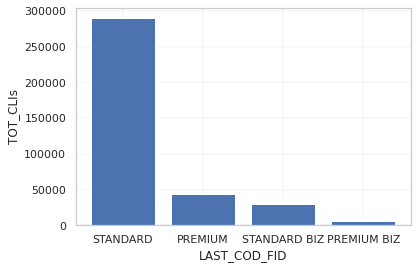

In [ ]:
#Variable LAST_COD_FID
#Compute distribution
df1_dist_codfid = df_1_cli_fid_clean.groupby('LAST_COD_FID', as_index = False)[['ID_CLI']].nunique()
df1_dist_codfid.rename(columns = {'ID_CLI' : 'TOT_CLIs'}, inplace = True)
df1_dist_codfid['PERCENT'] = df1_dist_codfid['TOT_CLIs']/df1_dist_codfid['TOT_CLIs'].sum()
df1_dist_codfid.sort_values('PERCENT', inplace = True, ascending = False)

#Plot distribution
plt.bar(df1_dist_codfid['LAST_COD_FID'], df1_dist_codfid['TOT_CLIs'],align='center') # A bar chart
plt.xlabel('LAST_COD_FID')
plt.ylabel('TOT_CLIs')
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

#ax = sns.barplot(x = 'LAST_COD_FID', y = 'TOT_CLIs', data = df1_dist_codfid)

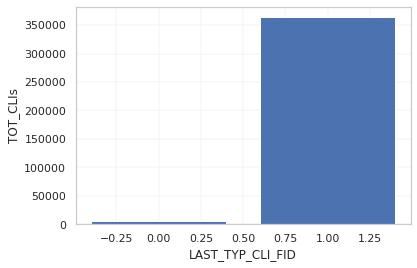

In [ ]:
#Variable LAST_TYP_CLI_FID
#Compute distribution
df1_dist_clifid = df_1_cli_fid_clean.groupby('LAST_TYP_CLI_FID', as_index = False)[['ID_CLI']].nunique()
df1_dist_clifid.rename(columns = {'ID_CLI' : 'TOT_CLIs'}, inplace = True)
df1_dist_clifid['PERCENT'] = df1_dist_clifid['TOT_CLIs']/df1_dist_clifid['TOT_CLIs'].sum()
df1_dist_clifid.sort_values('PERCENT', inplace = True, ascending = False)

#Plot distribution
plt.bar(df1_dist_clifid['LAST_TYP_CLI_FID'], df1_dist_clifid['TOT_CLIs'],align='center') # A bar chart
plt.xlabel('LAST_TYP_CLI_FID')
plt.ylabel('TOT_CLIs')
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

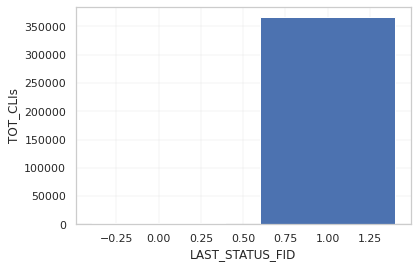

In [ ]:
#Variable LAST_STATUS_FID
#Compute distribution
df1_dist_statusfid = df_1_cli_fid_clean.groupby('LAST_STATUS_FID', as_index = False)[['ID_CLI']].nunique()
df1_dist_statusfid.rename(columns = {'ID_CLI' : 'TOT_CLIs'}, inplace = True)
df1_dist_statusfid['PERCENT'] = df1_dist_statusfid['TOT_CLIs']/df1_dist_statusfid['TOT_CLIs'].sum()
df1_dist_statusfid.sort_values('PERCENT', inplace = True, ascending = False)

#Plot distribution
plt.bar(df1_dist_statusfid['LAST_STATUS_FID'], df1_dist_statusfid['TOT_CLIs'],align='center') # A bar chart
plt.xlabel('LAST_STATUS_FID')
plt.ylabel('TOT_CLIs')
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

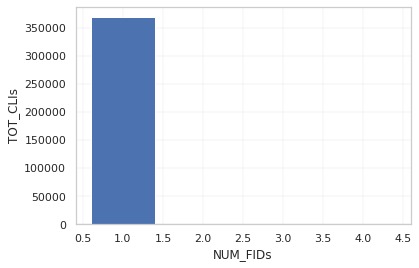

In [ ]:
#Variable NUM_FIDs
#Compute distribution
df1_dist_numfid = df_1_cli_fid_clean.groupby('NUM_FIDs', as_index = False)[['ID_CLI']].nunique()
df1_dist_numfid.rename(columns = {'ID_CLI' : 'TOT_CLIs'}, inplace = True)
df1_dist_numfid['PERCENT'] = df1_dist_numfid['TOT_CLIs']/df1_dist_numfid['TOT_CLIs'].sum()
df1_dist_numfid.sort_values('PERCENT', inplace = True, ascending = False)

#Plot distribution
plt.bar(df1_dist_numfid['NUM_FIDs'], df1_dist_numfid['TOT_CLIs'],align='center') # A bar chart
plt.xlabel('NUM_FIDs')
plt.ylabel('TOT_CLIs')
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

#ax = sns.barplot(x = 'NUM_FIDs', y = 'TOT_CLIs', data = df1_dist_numfid)

In [ ]:
#FINAL REVIEW df_1_clean
df_1_cli_fid_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369472 entries, 0 to 369471
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID_CLI            369472 non-null  int64         
 1   ID_FID            369472 non-null  int64         
 2   LAST_COD_FID      369472 non-null  object        
 3   LAST_TYP_CLI_FID  369472 non-null  category      
 4   LAST_STATUS_FID   369472 non-null  category      
 5   LAST_DT_ACTIVE    369472 non-null  datetime64[ns]
 6   FIRST_ID_NEG      369472 non-null  int64         
 7   FIRST_DT_ACTIVE   369472 non-null  datetime64[ns]
 8   NUM_FIDs          369472 non-null  category      
dtypes: category(3), datetime64[ns](2), int64(3), object(1)
memory usage: 20.8+ MB


In [ ]:
df_1_cli_fid_clean.describe()

,ID_CLI,ID_FID,FIRST_ID_NEG
count,369472.000000,369472.000000,369472.000000
mean,462540.932531,459334.542637,22.098952
std,267744.180842,265880.631039,15.777939
min,1.000000,3.000000,1.000000
25%,230783.250000,228930.750000,6.000000
50%,462062.500000,458832.000000,23.000000
75%,693196.750000,688329.750000,36.000000
max,934919.000000,928121.000000,49.000000


In [ ]:
df1 = df_1_cli_fid_clean
df1.to_csv('df1.csv', index=False)
df1.to_csv('df1_zip.csv', index=False, compression='gzip')

# df2

In [ ]:
#Check for duplicates
print('Check for duplicates')
print(f'Number of rows duplicated = {len(df2[df2.duplicated()])}')
print(f"Number of ID_CLI's values duplicated = {len(df2[df2.duplicated('ID_CLI')])}")

Check for duplicates
Number of rows duplicated = 0
Number of ID_CLI's values duplicated = 0


In [ ]:
# format numerical categories as categorical 
df2 = df2.astype({'TYP_CLI_ACCOUNT': 'category'})

In [ ]:
# CLEANING MISSING VALUES in df_2
# filling missing value using fillna() 
df2["W_PHONE"] = df2["W_PHONE"].fillna(0)
print(sum(df2["W_PHONE"].isnull()))
df2["EMAIL_PROVIDER"] = df2["EMAIL_PROVIDER"].fillna("(missing)")
print(sum(df2["EMAIL_PROVIDER"].isnull()))
df2["TYP_JOB"] = df2["TYP_JOB"].fillna("(missing)")
print(sum(df2["TYP_JOB"].isnull()))

0
0
0


In [ ]:
# tutti gli id in df1 sono anche in df2
df1['ID_CLI'].isin(df2['ID_CLI']).value_counts()
# True= comune
# False= diverso

True    369472
Name: ID_CLI, dtype: int64

In [ ]:
df2['EMAIL_PROVIDER']

0          libero.it
1          gmail.com
2           yahoo.it
3          libero.it
4          gmail.com
             ...    
369467     libero.it
369468     gmail.com
369469     gmail.com
369470     libero.it
369471    hotmail.it
Name: EMAIL_PROVIDER, Length: 369472, dtype: object

In [ ]:
# ci sono troppi valori diversi per EMAIL_PROVIDER
pd.set_option("display.max_rows", None)
df2['EMAIL_PROVIDER'].value_counts()
df2['EMAIL_PROVIDER'].value_counts(normalize=True) * 100 # percentuale

gmail.com                       41.006626
libero.it                       15.639074
hotmail.it                       7.767300
alice.it                         4.906190
yahoo.it                         4.476117
hotmail.com                      2.727135
virgilio.it                      2.479484
tiscali.it                       2.363643
live.it                          2.147930
(missing)                        1.593896
icloud.com                       1.010902
yahoo.com                        0.882070
gmail.it                         0.613308
tin.it                           0.590843
outlook.it                       0.551869
fastwebnet.it                    0.473378
inwind.it                        0.409774
email.it                         0.298534
me.com                           0.279859
live.com                         0.226539
outlook.com                      0.188106
msn.com                          0.176739
tim.it                           0.125043
ymail.com                        0

In [ ]:
df2['EMAIL_PROVIDER'].value_counts().head(20)

gmail.com        151508
libero.it         57782
hotmail.it        28698
alice.it          18127
yahoo.it          16538
hotmail.com       10076
virgilio.it        9161
tiscali.it         8733
live.it            7936
(missing)          5889
icloud.com         3735
yahoo.com          3259
gmail.it           2266
tin.it             2183
outlook.it         2039
fastwebnet.it      1749
inwind.it          1514
email.it           1103
me.com             1034
live.com            837
Name: EMAIL_PROVIDER, dtype: int64

In [ ]:
# calcolo probabilità cumulate
from collections import Counter
items = Counter(df2['ID_CLI']).keys()
out = np.cumsum(df2['EMAIL_PROVIDER'].value_counts()) / len(items)
out

gmail.com                       0.410066
libero.it                       0.566457
hotmail.it                      0.644130
alice.it                        0.693192
yahoo.it                        0.737953
hotmail.com                     0.765224
virgilio.it                     0.790019
tiscali.it                      0.813656
live.it                         0.835135
(missing)                       0.851074
icloud.com                      0.861183
yahoo.com                       0.870004
gmail.it                        0.876137
tin.it                          0.882045
outlook.it                      0.887564
fastwebnet.it                   0.892298
inwind.it                       0.896395
email.it                        0.899381
me.com                          0.902179
live.com                        0.904445
outlook.com                     0.906326
msn.com                         0.908093
tim.it                          0.909344
ymail.com                       0.910534
teletu.it       

In [ ]:
name_providers = []
for idx, name in enumerate(df2['EMAIL_PROVIDER'].value_counts().head(20).index.tolist()):
    name_providers.append(name)
name_providers

['gmail.com',
 'libero.it',
 'hotmail.it',
 'alice.it',
 'yahoo.it',
 'hotmail.com',
 'virgilio.it',
 'tiscali.it',
 'live.it',
 '(missing)',
 'icloud.com',
 'yahoo.com',
 'gmail.it',
 'tin.it',
 'outlook.it',
 'fastwebnet.it',
 'inwind.it',
 'email.it',
 'me.com',
 'live.com']

In [ ]:
# vengono mantenuti i primi 20 che hanno una frequenza cumulata < 85% e gli altri vengono nominati come "other"
for i in df2['EMAIL_PROVIDER']:
  if (i not in name_providers):
    df2['EMAIL_PROVIDER'] = df2['EMAIL_PROVIDER'].replace(i,'other')

In [ ]:
df2['EMAIL_PROVIDER'].value_counts()

gmail.com        151508
libero.it         57782
other             35305
hotmail.it        28698
alice.it          18127
yahoo.it          16538
hotmail.com       10076
virgilio.it        9161
tiscali.it         8733
live.it            7936
(missing)          5889
icloud.com         3735
yahoo.com          3259
gmail.it           2266
tin.it             2183
outlook.it         2039
fastwebnet.it      1749
inwind.it          1514
email.it           1103
me.com             1034
live.com            837
Name: EMAIL_PROVIDER, dtype: int64

In [ ]:
df2.to_csv('df2.csv', index=False)
df2.to_csv('df2_zip.csv', index=False, compression='gzip')

# df3

In [ ]:
#Check for duplicates
print('Check for duplicates')
print(f'Number of rows duplicated = {len(df3[df3.duplicated()])}')
print(f"Number of ID_ADDRESS's values duplicated = {len(df3[df3.duplicated('ID_ADDRESS')])}") 
# ci sono dei duplicati

Check for duplicates
Number of rows duplicated = 849999
Number of ID_ADDRESS's values duplicated = 850002


In [ ]:
df3 = df3.drop_duplicates()

In [ ]:
#Check for duplicates
print('Check for duplicates')
print(f'Number of rows duplicated = {len(df3[df3.duplicated()])}')
print(f"Number of ID_ADDRESS's values duplicated = {len(df3[df3.duplicated('ID_ADDRESS')])}") 

Check for duplicates
Number of rows duplicated = 0
Number of ID_ADDRESS's values duplicated = 3


In [ ]:
df3.dtypes

ID_ADDRESS     int64
CAP           object
PRV           object
REGION        object
dtype: object

In [ ]:
# format numerical categories as categorical 
df3 = df3.astype({'CAP': 'category'})

# CLEANING MISSING VALUES in df_3
df3.isnull().sum() 

ID_ADDRESS        0
CAP             121
PRV           45643
REGION        23864
dtype: int64

In [ ]:
df3.dropna(axis='index', inplace=True)

In [ ]:
df3.head()

,ID_ADDRESS,CAP,PRV,REGION
0,1337,20083.0,MI,LOMBARDIA
1,1344,20024.0,MI,LOMBARDIA
2,1347,20090.0,MI,LOMBARDIA
14,1352,20123.0,MI,LOMBARDIA
15,1353,20080.0,MI,LOMBARDIA


In [ ]:
# ci sono degli address che non sono mappati in df2
df2['ID_ADDRESS'].isin(df3['ID_ADDRESS']).value_counts()
#df3['ID_ADDRESS'].isin(df2['ID_ADDRESS']).value_counts()

True     316128
False     53344
Name: ID_ADDRESS, dtype: int64

In [ ]:
df3.to_csv('df3.csv', index=False)
df3.to_csv('df3_zip.csv', index=False, compression='gzip')

# df4

In [ ]:
#Check for duplicates
print('Check for duplicates')
print(f'Number of rows duplicated = {len(df4[df4.duplicated()])}')
print(f"Number of ID_CLI's values duplicated = {len(df4[df4.duplicated('ID_CLI')])}") 
# NON ci sono duplicati

Check for duplicates
Number of rows duplicated = 0
Number of ID_CLI's values duplicated = 0


In [ ]:
df4.head()

,ID_CLI,FLAG_PRIVACY_1,FLAG_PRIVACY_2,FLAG_DIRECT_MKT
0,4691,1,1,1
1,3434,0,1,0
2,3533,1,1,1
3,9866,1,1,1
4,5799,1,1,1


In [ ]:
# format boolean as categorical 
df4 = df4.astype({'FLAG_PRIVACY_1': 'category'})
df4 = df4.astype({'FLAG_PRIVACY_2': 'category'})
df4 = df4.astype({'FLAG_DIRECT_MKT': 'category'})

In [ ]:
df1['ID_CLI'].isin(df4['ID_CLI']).value_counts()
df4['ID_CLI'].isin(df1['ID_CLI']).value_counts()
# tutti gli ID_CLI in df1 sono anche in df4 e viceversa

True    369472
Name: ID_CLI, dtype: int64

In [ ]:
df4.to_csv('df4.csv', index=False)
df4.to_csv('df4__zip.csv', index=False, compression='gzip')

# df7

In [ ]:
df7.head()

,ID_SCONTRINO,ID_CLI,ID_NEG,ID_ARTICOLO,COD_REPARTO,DIREZIONE,IMPORTO_LORDO,SCONTO,DATETIME
0,51299709701/05/18718488513770,318714,48,34216854,2,1,"22,8","0,05",2018-05-01T071848
1,51299709701/05/18718488513770,318714,48,34216854,2,1,"22,75",0,2018-05-01T071848
2,51399406901/05/18718488528430,324419,47,36167733,9,1,1290,491,2018-05-01T071848
3,511499219301/05/18718488544998,332611,36,32404540,13,1,134,"34,1",2018-05-01T071848
4,511599623601/05/18718498530796,325589,35,35811412,9,1,399,0,2018-05-01T071849


In [ ]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4263220 entries, 0 to 4263219
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ID_SCONTRINO   object
 1   ID_CLI         int64 
 2   ID_NEG         int64 
 3   ID_ARTICOLO    int64 
 4   COD_REPARTO    int64 
 5   DIREZIONE      int64 
 6   IMPORTO_LORDO  object
 7   SCONTO         object
 8   DATETIME       object
dtypes: int64(5), object(4)
memory usage: 292.7+ MB


In [ ]:
df7.describe()

,ID_CLI,ID_NEG,ID_ARTICOLO,COD_REPARTO,DIREZIONE
count,4.263220e+06,4.263220e+06,4.263220e+06,4.263220e+06,4.263220e+06
mean,4.114329e+05,2.593355e+01,3.802259e+07,7.392967e+00,8.865702e-01
std,2.417535e+05,1.415556e+01,1.167478e+07,3.821043e+00,4.625940e-01
min,5.000000e+00,2.000000e+00,1.692100e+04,1.000000e+00,-1.000000e+00
25%,2.112005e+05,1.400000e+01,3.414180e+07,3.000000e+00,1.000000e+00
50%,4.118210e+05,2.700000e+01,3.555845e+07,7.000000e+00,1.000000e+00
75%,6.016720e+05,3.800000e+01,3.614446e+07,1.100000e+01,1.000000e+00
max,9.347290e+05,4.900000e+01,8.223148e+07,1.400000e+01,1.000000e+00


In [ ]:
df7.shape

(4263220, 9)

In [ ]:
#Formatting dates and times
df7['DATETIME'] = pd.to_datetime(df7['DATETIME'])
df7['ORA'] = df7['DATETIME'].dt.hour
df7['DATA'] = df7['DATETIME'].dt.date
df7['DATA'] = pd.to_datetime(df7['DATA'])

In [ ]:
#Formatting boolean as category
df7 = df7.astype({'DIREZIONE': 'category'})
#Formatting numerical categories as category
df7 = df7.astype({'COD_REPARTO': 'category'})

df7['IMPORTO_LORDO'] = df7['IMPORTO_LORDO'].replace(',','.', regex=True)
df7 = df7.astype({'IMPORTO_LORDO': 'float'})

In [ ]:
df7['SCONTO'] = df7['SCONTO'].replace(',','.', regex=True)
df7 = df7.astype({'SCONTO': 'float'})

In [ ]:
#Elimino le righe che hanno DIREZIONE = 1 e con IMPORTO_LORDO negativo perché non sono casi possibili, sono degli errori.
#df7.drop(df7.index[(df7['DIREZIONE'] == 1) & (df7['IMPORTO_LORDO'] < 0)], inplace = True)

In [ ]:
#Creo la colonna che considera l'importo netto perché così ne elimino due (le eliminiamo alla fine per via di altre operazioni)
df7['IMPORTO_NETTO'] = df7['IMPORTO_LORDO'] - df7['SCONTO']
df7.reset_index(inplace = True, drop = True)

In [ ]:
df7.drop(df7.index[(df7['IMPORTO_NETTO'] < 0)], inplace = True)
df7.reset_index(inplace = True, drop = True)

In [ ]:
len(df7[(df7['IMPORTO_NETTO'] < 0)])

0

In [ ]:
#Controllo se ci sono delle righe duplicate in base a tutte le colonne tranne l'IMPORTO_NETTO
subset= df7[['ID_SCONTRINO', 'ID_CLI', 'ID_NEG', 'ID_ARTICOLO', 'DIREZIONE', 'COD_REPARTO', 'DATETIME', 'ORA', 'DATA']]
print('Check for duplicates:')
print(f'Number of duplicated purchases = {len(subset[subset.duplicated()])}')
#I duplicati sono normali perché se compro più quantità di uno stesso prodotto nello stesso scontrino
#viene duplicata la riga relativa perché non tiene conto delle quantità

Check for duplicates:
Number of duplicated purchases = 268628


In [ ]:
len(df7[(df7['IMPORTO_NETTO'] == 0)])

12192

In [ ]:
# si nota che 12192 righe hanno importo netto pari a 0 poichè è stato applicato uno sconto del 100%, ovvero l'importo lordo equivale allo 
# sconto applicato.
df7[(df7['IMPORTO_NETTO'] == 0)]

,ID_SCONTRINO,ID_CLI,ID_NEG,ID_ARTICOLO,COD_REPARTO,DIREZIONE,IMPORTO_LORDO,SCONTO,DATETIME,ORA,DATA,IMPORTO_NETTO
493,51183344801/05/181518198571644,346789,33,34877003,12,1,2.98,2.98,2018-05-01 15:18:19,15,2018-05-01,0.0
819,51262818201/05/181818128495671,308165,26,36151640,9,1,1.76,1.76,2018-05-01 18:18:12,18,2018-05-01,0.0
820,51262818201/05/181818128495671,308165,26,36151640,9,1,11.99,11.99,2018-05-01 18:18:12,18,2018-05-01,0.0
1503,513519246302/05/18817008415970,263871,17,35767872,7,1,130.00,130.00,2018-05-02 08:17:00,8,2018-05-02,0.0
1791,51417851202/05/18938078572727,347450,12,34544706,3,1,0.63,0.63,2018-05-02 09:38:07,9,2018-05-02,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4016084,513210382330/04/191732058576092,349122,20,35215012,12,1,21.80,21.80,2019-04-30 17:32:05,17,2019-04-30,0.0
4016085,513210382330/04/191732058576092,349122,20,35215012,12,1,28.34,28.34,2019-04-30 17:32:05,17,2019-04-30,0.0
4016147,5137245530/04/191735309755777,913856,47,35215194,12,1,6.95,6.95,2019-04-30 17:35:30,17,2019-04-30,0.0
4017542,513123375330/04/191846459527864,818642,21,48020504,2,1,1.00,1.00,2019-04-30 18:46:45,18,2019-04-30,0.0


In [ ]:
#In seguito controllo i duplicati per vedere se c'è qualcosa che non torna
df7[(df7['ID_SCONTRINO'] == '51183329701/05/181123338499039') & (df7['ID_CLI'] == 310038) & (df7['ID_ARTICOLO'] == 35573020)]
#In questo caso, e non è l'unico, lo stesso articolo viene acquistato dallo stesso cliente nello 
#stesso scontrino dello stesso giorno ma l'IMPORTO_NETTO è diverso

,ID_SCONTRINO,ID_CLI,ID_NEG,ID_ARTICOLO,COD_REPARTO,DIREZIONE,IMPORTO_LORDO,SCONTO,DATETIME,ORA,DATA,IMPORTO_NETTO
132,51183329701/05/181123338499039,310038,33,35573020,3,1,16.50,2.05,2018-05-01 11:23:33,11,2018-05-01,14.45
133,51183329701/05/181123338499039,310038,33,35573020,3,1,1.50,0.19,2018-05-01 11:23:33,11,2018-05-01,1.31
134,51183329701/05/181123338499039,310038,33,35573020,3,1,3.36,2.05,2018-05-01 11:23:33,11,2018-05-01,1.31
135,51183329701/05/181123338499039,310038,33,35573020,3,1,14.64,0.19,2018-05-01 11:23:33,11,2018-05-01,14.45


In [ ]:
#A meno di particoli offerte, di cui non siamo informati, non puoi avere lo stesso prodotto nello
#stesso scontrino venduto con valori di IMPORTO_NETTO diversi.
#Salvo a parte le righe che sono identiche quindi quelle che indicano un acquisto di più prodotti
#uguali in una stessa volta.
identical = df7[df7.duplicated(keep = False)]

In [ ]:
#Elimino da tutto il dataset i duplicati identici e non ne tengo nessuno
df7.drop_duplicates(inplace = True, keep = False)
df7.reset_index(inplace = True, drop = True)

In [ ]:
#Le righe rimaste non possono avere duplicati identici, quindi sono quelle con problemi, di queste non
#ne tengo nessuna perché non so qual è il prezzo esatto
df7.drop_duplicates(subset = ['ID_SCONTRINO', 'ID_CLI', 'ID_NEG', 'ID_ARTICOLO', 'COD_REPARTO', 'DIREZIONE', 'DATETIME', 'ORA', 'DATA'], inplace = True, keep = False)
df7.reset_index(inplace = True, drop = True)

In [ ]:
#Riunisco al dataset quelli identici perché li volevo tenere
df7 = df7.append(identical, ignore_index=True)

## Overview

In [ ]:
#Compute aggregate
df7_overview = pd.DataFrame({'MIN_DATE' : [df7['DATA'].min()], 'MAX_DATE' : [df7['DATA'].max()], 
                             'TOT_TICs' : [df7['ID_SCONTRINO'].nunique()], 'TOT_CLIs' : [df7['ID_CLI'].nunique()]})
df7_overview
#Il periodo di tempo va dal 01-05-2018 al 30-04-2019

,MIN_DATE,MAX_DATE,TOT_TICs,TOT_CLIs
0,2018-05-01,2019-04-30,903157,211608


In [ ]:
#Variable DIREZIONE
#Compute aggregate
df7_dist_direction = df7.groupby('DIREZIONE', as_index = False)[['ID_SCONTRINO', 'ID_CLI']].nunique()
df7_dist_direction.rename(columns = {'ID_SCONTRINO' : 'TOT_TICs', 'ID_CLI' : 'TOT_CLIs'}, inplace = True)
#Sono i risultati delle divisioni, li ho messi così perché mi venivano NaN
df7_dist_direction['PERCENT_TICs'] = [0.09036657031066045, 0.9096334296893396]
df7_dist_direction['PERCENT_CLIs'] = [0.2197865399483321, 1.0]
df7_dist_direction

,DIREZIONE,TOT_TICs,TOT_CLIs,PERCENT_TICs,PERCENT_CLIs
0,-1,163,157,0.090367,0.219787
1,1,902994,211604,0.909633,1.000000


In [ ]:
# Variable ORA
#Compute aggregate
df7_dist_hour = df7.groupby(['ORA', 'DIREZIONE'])[['ID_SCONTRINO', 'ID_CLI']].nunique()
df7_dist_hour.reset_index(inplace = True)
df7_dist_hour.rename(columns = {'ID_SCONTRINO' : 'TOT_TICs', 'ID_CLI' : 'TOT_CLIs'}, inplace = True)
df7_dist_direction.rename(columns = {'TOT_TICs' : 'ALL_TOT_TICs', 'TOT_CLIs' : 'ALL_TOT_CLIs'}, inplace = True)
df7_dist_hour = pd.merge(df7_dist_hour, df7_dist_direction[['DIREZIONE', 'ALL_TOT_TICs', 'ALL_TOT_CLIs']], on = 'DIREZIONE', how = 'left')
df7_dist_hour['PERCENT_TICs'] = df7_dist_hour.TOT_TICs/df7_dist_hour.ALL_TOT_TICs
df7_dist_hour['PERCENT_CLIs'] = df7_dist_hour.TOT_CLIs/df7_dist_hour.ALL_TOT_CLIs
df7_dist_hour.drop(columns = {'ALL_TOT_TICs', 'ALL_TOT_CLIs'}, inplace = True)
df7_dist_hour.drop([0, 2, 4, 6], inplace =True)
df7_dist_hour.reset_index(inplace = True, drop = True)
df7_dist_hour
#plot

,ORA,DIREZIONE,TOT_TICs,TOT_CLIs,PERCENT_TICs,PERCENT_CLIs
0,3,1,2,2,0.000002,0.000009
1,4,1,4,4,0.000004,0.000019
2,5,1,2,2,0.000002,0.000009
3,6,1,32,32,0.000035,0.000151
4,7,-1,2,2,0.012270,0.012739
5,7,1,9161,6247,0.010145,0.029522
6,8,-1,3,3,0.018405,0.019108
7,8,1,17530,11550,0.019413,0.054583
8,9,-1,10,10,0.061350,0.063694
9,9,1,45343,29161,0.050214,0.137809


In [ ]:
#Variable COD_REPARTO
#Compute aggregate
df7_dist_dep = df7.groupby(['COD_REPARTO', 'DIREZIONE'])[['ID_SCONTRINO', 'ID_CLI']].nunique()
df7_dist_dep.rename(columns = {'ID_SCONTRINO' : 'TOT_TICs', 'ID_CLI' : 'TOT_CLIs'}, inplace = True)
df7_dist_dep.reset_index(inplace = True)
df7_dist_dep = pd.merge(df7_dist_dep, df7_dist_direction[['DIREZIONE', 'ALL_TOT_TICs', 'ALL_TOT_CLIs']], how = 'left', on = 'DIREZIONE')
df7_dist_dep['PERCENT_TICs'] = df7_dist_dep.TOT_TICs/df7_dist_dep.ALL_TOT_TICs
df7_dist_dep['PERCENT_CLIs'] = df7_dist_dep.TOT_CLIs/df7_dist_dep.ALL_TOT_CLIs
df7_dist_dep.drop(columns = {'ALL_TOT_TICs', 'ALL_TOT_CLIs'}, inplace = True)
df7_dist_dep

,COD_REPARTO,DIREZIONE,TOT_TICs,TOT_CLIs,PERCENT_TICs,PERCENT_CLIs
0,1,-1,1,1,0.006135,0.006369
1,1,1,64415,30371,0.071335,0.143528
2,2,-1,53,52,0.325153,0.331210
3,2,1,92146,53207,0.102045,0.251446
4,3,-1,16,16,0.098160,0.101911
5,3,1,229378,93089,0.254019,0.439921
6,4,-1,1,1,0.006135,0.006369
7,4,1,144383,73015,0.159894,0.345055
8,5,-1,19,19,0.116564,0.121019
9,5,1,41072,29837,0.045484,0.141004


In [ ]:
#Variable ID_ARTICOLO
#Compute aggregate
df7_dist_articolo = df7.groupby(['ID_ARTICOLO', 'DIREZIONE'])[['ID_SCONTRINO', 'ID_CLI']].nunique()
df7_dist_articolo.rename(columns = {'ID_SCONTRINO' : 'TOT_TICs', 'ID_CLI' : 'TOT_CLIs'}, inplace = True)
df7_dist_articolo.reset_index(inplace = True)
df7_dist_articolo.head()

,ID_ARTICOLO,DIREZIONE,TOT_TICs,TOT_CLIs
0,16921,-1,0,0
1,16921,1,5,5
2,16923,-1,0,0
3,16923,1,10,10
4,18278,-1,0,0


In [ ]:
#Distribution of customers by number of purchases
#Elimino quelli con DIREZIONE = -1, perché mi interessa che abbiano acquistato, se anche restituiscono ma fanno più acquisti sono clienti.
df7_dist_customer = df7.groupby(['ID_CLI', 'DIREZIONE'])[['ID_SCONTRINO']].nunique()
df7_dist_customer.reset_index(inplace = True)
df7_dist_customer.drop(df7_dist_customer.index[df7_dist_customer['ID_SCONTRINO'] == 0], inplace = True)
df7_dist_customer.drop(df7_dist_customer.index[df7_dist_customer['DIREZIONE'] == -1], inplace = True)
df7_dist_customer.rename(columns = {'ID_SCONTRINO' : 'TOT_SCONTRINI'}, inplace = True)
df7_dist_customer.reset_index(inplace = True, drop = True)
#df7_dist_customer = df7_dist_customer.groupby('TOT_SCONTRINI', as_index = False)[['ID_CLI']].count()
#df7_dist_customer.rename(columns = {'ID_CLI' : 'TOT_CLI'}, inplace = True)
df7_dist_customer.head()

,ID_CLI,DIREZIONE,TOT_SCONTRINI
0,5,1,1
1,18,1,5
2,23,1,9
3,28,1,1
4,30,1,2


In [ ]:
df7_dist_customer.sort_values(['TOT_SCONTRINI'], ascending = [False])
#I 3 id_cliente che registrano il numero maggiore di acquisti sono: 376925, 117212, 248975 con rispettivamente 177, 155, 154 acquisti

,ID_CLI,DIREZIONE,TOT_SCONTRINI
81302,376925,1,177
28423,117212,1,155
52520,248975,1,152
71789,341579,1,148
77272,362177,1,146
...,...,...,...
113600,496887,1,1
113597,496881,1,1
113596,496879,1,1
113595,496877,1,1


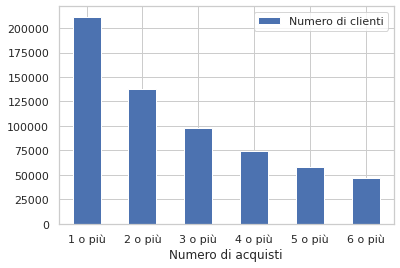

In [ ]:
df7_plot_dist_customer = pd.DataFrame({'Numero di acquisti':['1 o più', '2 o più', '3 o più', '4 o più', '5 o più', '6 o più'], 
                                       'Numero di clienti': [len(df7_dist_customer[df7_dist_customer['TOT_SCONTRINI'] >= 1]), 
                                                             len(df7_dist_customer[df7_dist_customer['TOT_SCONTRINI'] >= 2]), 
                                                             len(df7_dist_customer[df7_dist_customer['TOT_SCONTRINI'] >= 3]), 
                                                             len(df7_dist_customer[df7_dist_customer['TOT_SCONTRINI'] >= 4]), 
                                                             len(df7_dist_customer[df7_dist_customer['TOT_SCONTRINI'] >= 5]), 
                                                             len(df7_dist_customer[df7_dist_customer['TOT_SCONTRINI'] >= 6])]})
ax = df7_plot_dist_customer.plot.bar(x='Numero di acquisti', y='Numero di clienti', rot=0)

### The days for next purchase curve

In [ ]:
#Considero che ne fa uno al giorno
df7_day_next_purchase = df7.groupby('ID_CLI', as_index = False).agg(PRIMO_ACQUISTO = ('DATA', 'min'), 
                                                                    ULTIMO_ACQUISTO = ('DATA', 'max'), NUMERO_ACQUISTI = ('DATA', 'nunique'))
df7_day_next_purchase

,ID_CLI,PRIMO_ACQUISTO,ULTIMO_ACQUISTO,NUMERO_ACQUISTI
0,5,2018-11-23,2018-11-23,1
1,18,2018-07-23,2018-11-23,4
2,23,2018-10-04,2019-02-20,7
3,28,2018-10-11,2018-10-11,1
4,30,2018-06-11,2018-07-23,2
...,...,...,...,...
211603,934705,2019-04-30,2019-04-30,1
211604,934716,2019-04-30,2019-04-30,1
211605,934725,2019-04-30,2019-04-30,1
211606,934727,2019-04-30,2019-04-30,1


In [ ]:
df_7_next = df7.sort_values(by = 'DATA')
df_7_next.reset_index(inplace = True, drop = True)
df7_day_next = df_7_next.groupby(['ID_CLI', 'DATA']).agg(PRIMO_ACQUISTO = ('DATA', 'min'))
df7_day_next.reset_index(inplace = True)
df7_day_next.drop(['PRIMO_ACQUISTO'], axis = 1, inplace = True)
df7_day_next = df7_day_next.groupby('ID_CLI')[['DATA']].nth(-2)
df7_day_next.reset_index(inplace = True)
df7_day_next.rename(columns = {'DATA' : 'PENULTIMO_ACQUISTO'}, inplace = True)
df7_day_next

,ID_CLI,PENULTIMO_ACQUISTO
0,18,2018-08-11
1,23,2018-12-21
2,30,2018-06-11
3,32,2019-03-18
4,48,2019-04-26
...,...,...
133800,929975,2019-04-27
133801,930021,2019-04-27
133802,932402,2019-04-29
133803,933057,2019-04-29


In [ ]:
df7_day_next_purchase = pd.merge(df7_day_next_purchase, df7_day_next, on = 'ID_CLI', how = 'left')
df7_day_next_purchase['NEXT_PURCHASE_DAY'] = (df7_day_next_purchase['ULTIMO_ACQUISTO'] - df7_day_next_purchase['PENULTIMO_ACQUISTO']).dt.days
df7_day_next_purchase['NEXT_PURCHASE_DAY'] = df7_day_next_purchase['NEXT_PURCHASE_DAY'].fillna(0)
df7_day_next_purchase

,ID_CLI,PRIMO_ACQUISTO,ULTIMO_ACQUISTO,NUMERO_ACQUISTI,PENULTIMO_ACQUISTO,NEXT_PURCHASE_DAY
0,5,2018-11-23,2018-11-23,1,NaT,0.0
1,18,2018-07-23,2018-11-23,4,2018-08-11,104.0
2,23,2018-10-04,2019-02-20,7,2018-12-21,61.0
3,28,2018-10-11,2018-10-11,1,NaT,0.0
4,30,2018-06-11,2018-07-23,2,2018-06-11,42.0
...,...,...,...,...,...,...
211603,934705,2019-04-30,2019-04-30,1,NaT,0.0
211604,934716,2019-04-30,2019-04-30,1,NaT,0.0
211605,934725,2019-04-30,2019-04-30,1,NaT,0.0
211606,934727,2019-04-30,2019-04-30,1,NaT,0.0


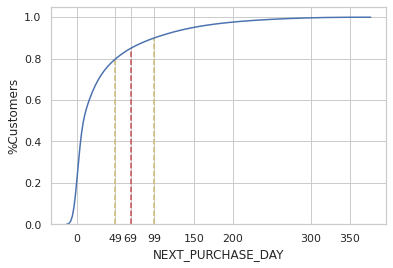

In [ ]:
ax = sns.kdeplot(data = df7_day_next_purchase, x = 'NEXT_PURCHASE_DAY', cumulative = True)
plt.xticks([0,49,69,99,150,200,300,350])
plt.vlines(x = 69, ymin = 0, ymax = 0.85, color='r', linestyle='--')
plt.vlines(x = 49, ymin = 0, ymax = 0.80, color='y', linestyle='--')
plt.vlines(x = 99, ymin = 0, ymax = 0.90, color='y', linestyle='--')
plt.ylabel('%Customers')
plt.savefig('NPDC.png')

In [ ]:
print('Last purchase: ' + str(df7.DATETIME.max()))
print('First purchase: ' + str(df7.DATETIME.min()))

Last purchase: 2019-04-30 21:57:25
First purchase: 2018-05-01 07:18:48


In [ ]:
## Set last date as point cut to calculate the day next purchase 
max_date = df7_day_next_purchase.NEXT_PURCHASE_DAY.max()

print('Summary: ', df7_day_next_purchase.NEXT_PURCHASE_DAY.describe())
print('80% ', np.percentile(a = df7_day_next_purchase.NEXT_PURCHASE_DAY, q = 80))
print('85% ', np.percentile(a = df7_day_next_purchase.NEXT_PURCHASE_DAY, q = 85))
print('90% ', np.percentile(a = df7_day_next_purchase.NEXT_PURCHASE_DAY, q = 90))

Summary:  count    211608.000000
mean         30.867141
std          52.863327
min           0.000000
25%           0.000000
50%           7.000000
75%          36.000000
max         363.000000
Name: NEXT_PURCHASE_DAY, dtype: float64
80%  49.0
85%  69.0
90%  99.0


### Altro grafico

In [ ]:
!pip install pandas plotnine --quiet

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 301'. Pick better value with 'binwidth'.


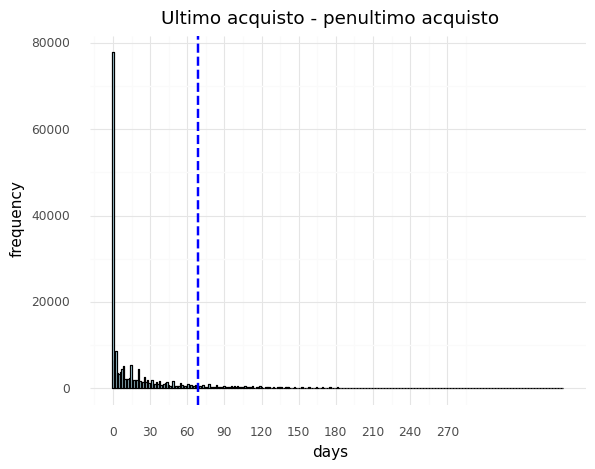

In [ ]:
from plotnine import *
from plotnine import ggplot, aes, geom_line

p = ggplot(df7_day_next_purchase, aes(x= df7_day_next_purchase['NEXT_PURCHASE_DAY'])) + geom_histogram(color="black", fill="lightblue") \
+ geom_vline(aes(xintercept = 69), color="blue", linetype="dashed", size=1) \
+ labs(title = "Ultimo acquisto - penultimo acquisto", x = "days", y = "frequency") \
+ scale_x_continuous(breaks=range(0,300,30)) + theme_minimal()

print(p)

### df7_churn

In [ ]:
# NB !!!
# Data la "the days for next purchase curve" si nota per circa il 90% dei clienti passano circa 99 giorni 
# per il successivo acquisto, per l'80% passano 49 giorni
# Questo significa che dato che la maggior parte delle persone acquista dopo 69 giorni, 
# se un cliente non dovesse acquistare questo deve essere un campanello d'allarme, 
# il cliente potrebbe essere un possibile churn

# creiamo la colonna CHURN supponendo: 0 = NON CHURN, 1 = CHURN
# si suppone un periodo di holdout di circa 69 giorni, pertanto tutti gli acquisti effettuati 

# quindi consideriamo un cliente come churn i clienti che non riacquistano entro due mesi e mezzo (entro il 2019/02/19)

#creiamo la colonna dei churner
df_churn1 = df7.groupby(['ID_CLI'])[['DATA']].max()
df_churn1.rename(columns = {'DATA' : 'LAST_PURCHASE_DATE'}, inplace = True)
df_churn1.reset_index(inplace = True)

df_churn2 = df7.groupby(['ID_CLI'])[['IMPORTO_LORDO']].sum()
df_churn2.rename(columns = {'IMPORTO_LORDO' : 'TOTAL_PURCHASE'}, inplace = True)
df_churn2.reset_index(inplace = True)

df_churn3 = df7.groupby(['ID_CLI', 'DIREZIONE'])[['ID_SCONTRINO']].nunique()
df_churn3.reset_index(inplace = True)
df_churn3.drop(df_churn3.index[df_churn3['ID_SCONTRINO'] == 0], inplace = True)
df_churn3.drop(df_churn3.index[df_churn3['DIREZIONE'] == -1], inplace = True)
df_churn3.rename(columns = {'ID_SCONTRINO' : 'NUMBER_OF_PURCHASE'}, inplace = True)
df_churn3.reset_index(inplace = True, drop = True)

df_churn = pd.merge(left=df_churn1, right=df_churn2, how='left', on='ID_CLI')
pd.merge(left=df_churn, right=df_churn3, how='left', on='ID_CLI')

,ID_CLI,LAST_PURCHASE_DATE,TOTAL_PURCHASE,DIREZIONE,NUMBER_OF_PURCHASE
0,5,2018-11-23,221.51,1,1.0
1,18,2018-11-23,381.85,1,5.0
2,23,2019-02-20,1806.05,1,9.0
3,28,2018-10-11,2071.64,1,1.0
4,30,2018-07-23,1094.10,1,2.0
...,...,...,...,...,...
211603,934705,2019-04-30,275.79,1,1.0
211604,934716,2019-04-30,6.99,1,1.0
211605,934725,2019-04-30,26.39,1,1.0
211606,934727,2019-04-30,260.72,1,1.0


In [ ]:
from datetime import date

CHURN =[]
# 1 = TRUE, 0 = FALSE
for i in range(len(df_churn['LAST_PURCHASE_DATE'])):
  if (df_churn['LAST_PURCHASE_DATE'][i] < date(2019, 2, 19)):
    CHURN.append(1)
  else:
    CHURN.append(0)

df_churn['CHURN'] = CHURN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


In [ ]:
df_churn

,ID_CLI,LAST_PURCHASE_DATE,TOTAL_PURCHASE,CHURN
0,5,2018-11-23,221.51,1
1,18,2018-11-23,381.85,1
2,23,2019-02-20,1806.05,0
3,28,2018-10-11,2071.64,1
4,30,2018-07-23,1094.10,1
...,...,...,...,...
211603,934705,2019-04-30,275.79,0
211604,934716,2019-04-30,6.99,0
211605,934725,2019-04-30,26.39,0
211606,934727,2019-04-30,260.72,0


### Final review

In [ ]:
df7.drop(columns = ['IMPORTO_LORDO', 'SCONTO'], inplace = True) # siccome abbiamo aggiunto la colonna IMPORTO_NETTO, queste due colonne non ci servono più

In [ ]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900376 entries, 0 to 3900375
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ID_SCONTRINO   object        
 1   ID_CLI         int64         
 2   ID_NEG         int64         
 3   ID_ARTICOLO    int64         
 4   COD_REPARTO    category      
 5   DIREZIONE      category      
 6   DATETIME       datetime64[ns]
 7   ORA            int64         
 8   DATA           datetime64[ns]
 9   IMPORTO_NETTO  float64       
dtypes: category(2), datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 245.5+ MB


In [ ]:
df7.describe()

,ID_CLI,ID_NEG,ID_ARTICOLO,ORA,IMPORTO_NETTO
count,3.900376e+06,3.900376e+06,3.900376e+06,3.900376e+06,3.900376e+06
mean,4.114402e+05,2.592354e+01,3.800511e+07,1.445867e+01,3.105703e+01
std,2.424305e+05,1.416725e+01,1.175682e+07,3.436710e+00,9.461920e+01
min,5.000000e+00,2.000000e+00,1.692100e+04,3.000000e+00,0.000000e+00
25%,2.103360e+05,1.400000e+01,3.413591e+07,1.100000e+01,2.990000e+00
50%,4.111140e+05,2.700000e+01,3.554809e+07,1.500000e+01,7.900000e+00
75%,6.021150e+05,3.800000e+01,3.614167e+07,1.700000e+01,2.198000e+01
max,9.347290e+05,4.900000e+01,8.223148e+07,2.200000e+01,1.536920e+04


### Save

In [ ]:
df7.to_csv('df7.csv', index=False)

In [ ]:
df7_churn = pd.merge(left=df_churn, right=df7, how='left', on='ID_CLI')
df7_churn.to_csv('df7_churn.csv', index=False)
#df7_churn.to_csv('df7_churn_zip.csv', index=False, compression='gzip')

In [ ]:
## Save in zip format
df1 = pd.read_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df3.csv')
df7 = pd.read_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df7.csv')
df7_churn = pd.read_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df7_churn.csv')

In [ ]:
df1.to_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df1_zip.csv', index = False, compression = 'gzip')
df2.to_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df2_zip.csv', index = False, compression = 'gzip')
df3.to_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df3_zip.csv', index = False, compression = 'gzip')
df7.to_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df7_zip.csv', index = False, compression = 'gzip')
df7_churn.to_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df7_churn_zip.csv', index = False, compression = 'gzip')

In [ ]:
df4 = pd.read_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df4.csv')
df4.to_csv('/content/drive/MyDrive/Progetto_Web/Dataset_Clean/df4_zip.csv', index = False, compression = 'gzip')